In [1]:
import numpy as np
import pandas as pd
import scanpy as sc

In [2]:
# Settings

sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

/Users/mscavino/miniconda3/envs/scanpy/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


scanpy==1.9.1 anndata==0.8.0 umap==0.5.3 numpy==1.23.3 scipy==1.9.1 pandas==1.5.0 scikit-learn==1.1.2 statsmodels==0.13.2 python-igraph==0.10.1 pynndescent==0.5.7


In [3]:
results_file = 'Scanpy_test/write/pbmc3k.h5ad'  # the file that will store the analysis results

In [4]:
# Loading data

adata = sc.read_10x_mtx(
    'Scanpy_test/data/filtered_gene_bc_matrices/hg19/',  # the directory with the `.mtx` file
    var_names='gene_symbols',                # use gene symbols for the variable names (variables-axis index)
    cache=True)                              # write a cache file for faster subsequent reading


... reading from cache file cache/Scanpy_test-data-filtered_gene_bc_matrices-hg19-matrix.h5ad


In [5]:
adata.var_names_make_unique()  # this is unnecessary if using `var_names='gene_ids'` in `sc.read_10x_mtx`

In [6]:
adata

AnnData object with n_obs × n_vars = 2700 × 32738
    var: 'gene_ids'

normalizing counts per cell
    finished (0:00:00)


/Users/mscavino/miniconda3/envs/scanpy/lib/python3.8/site-packages/seaborn/categorical.py:470: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


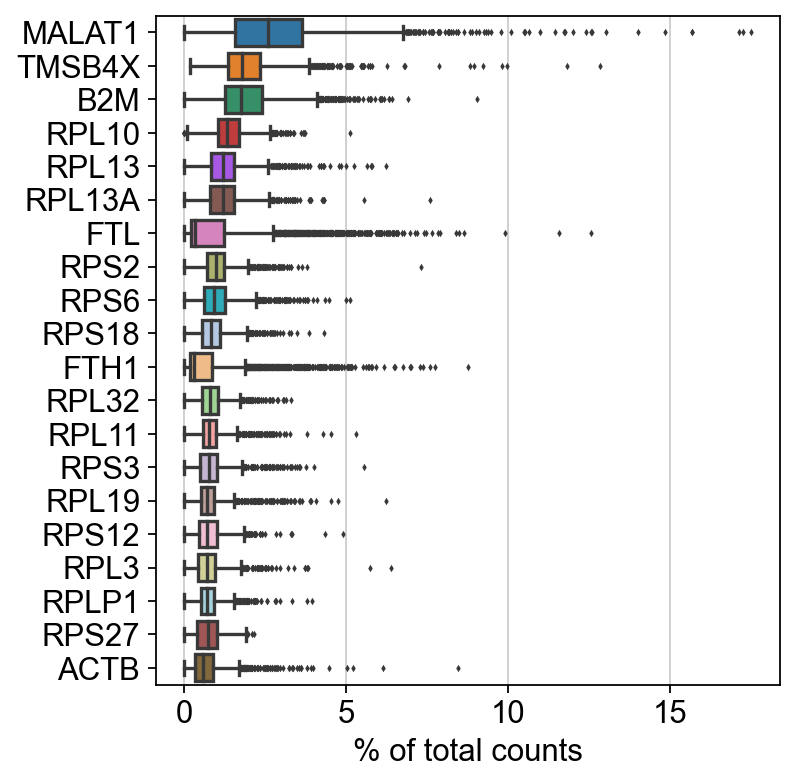

In [7]:
# Plot the 20 highest expressed genes in the dataset

sc.pl.highest_expr_genes(adata, n_top=20, )

In [8]:
# Filter cells

sc.pp.filter_cells(adata, min_genes=200) # Filter cells with 200 or less genes  
sc.pp.filter_genes(adata, min_cells=3) # Filter genes expressed in 3 or less cells

filtered out 19024 genes that are detected in less than 3 cells


In [9]:
# Filtering mitochondiral genes

adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

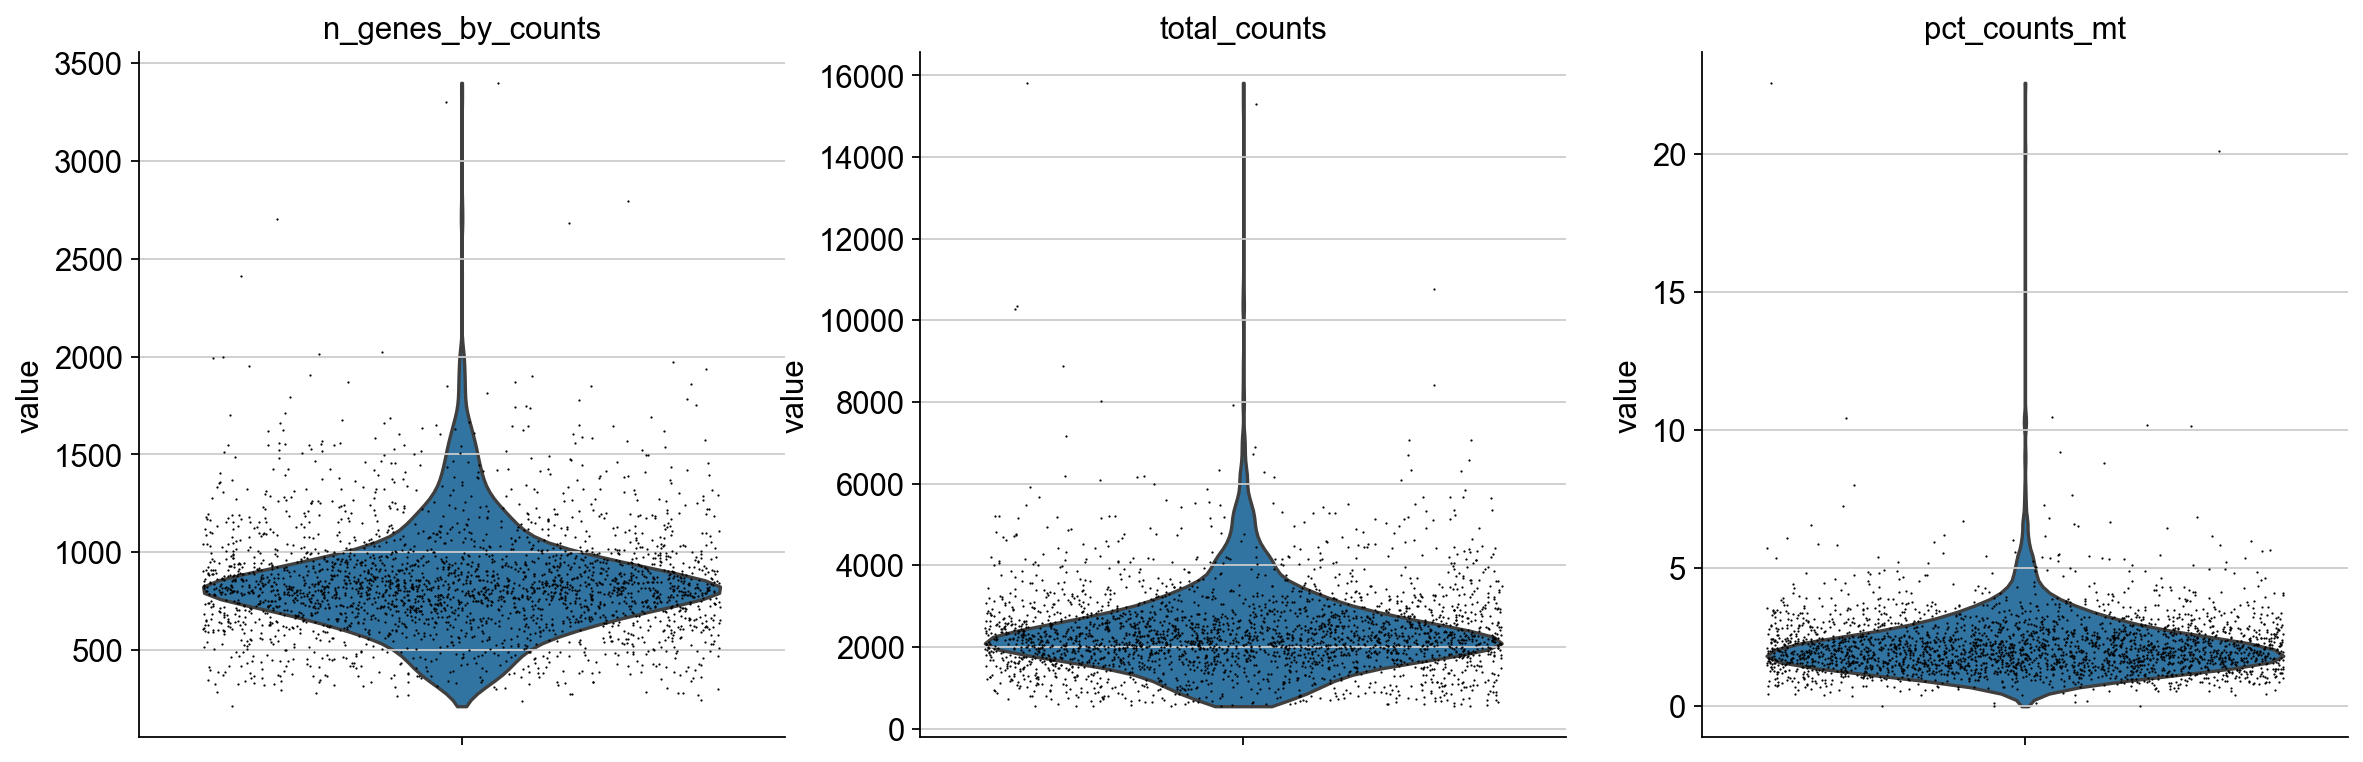

In [10]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

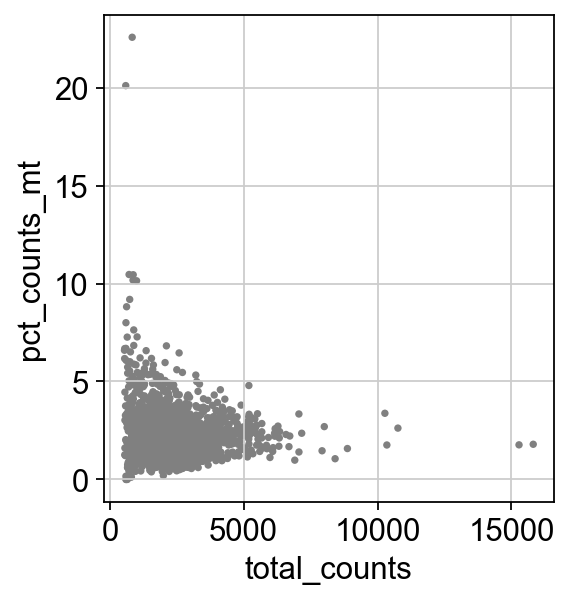

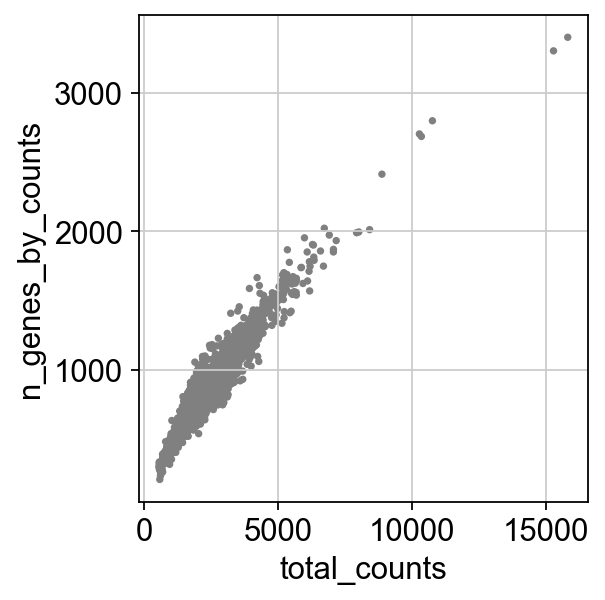

In [11]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

In [12]:
# Quality control

adata = adata[adata.obs.n_genes_by_counts < 2500, :] # Remove cells that express more than 2500 genes
adata = adata[adata.obs.pct_counts_mt < 5, :] # Remove cells that express more than 5% of mitochondrial genes

In [13]:
# Normalize data

sc.pp.normalize_total(adata, target_sum=1e4)

normalizing counts per cell
    finished (0:00:00)


/Users/mscavino/miniconda3/envs/scanpy/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [14]:
sc.pp.log1p(adata)

In [15]:
# Find the most variable genes (here n = 246)

sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


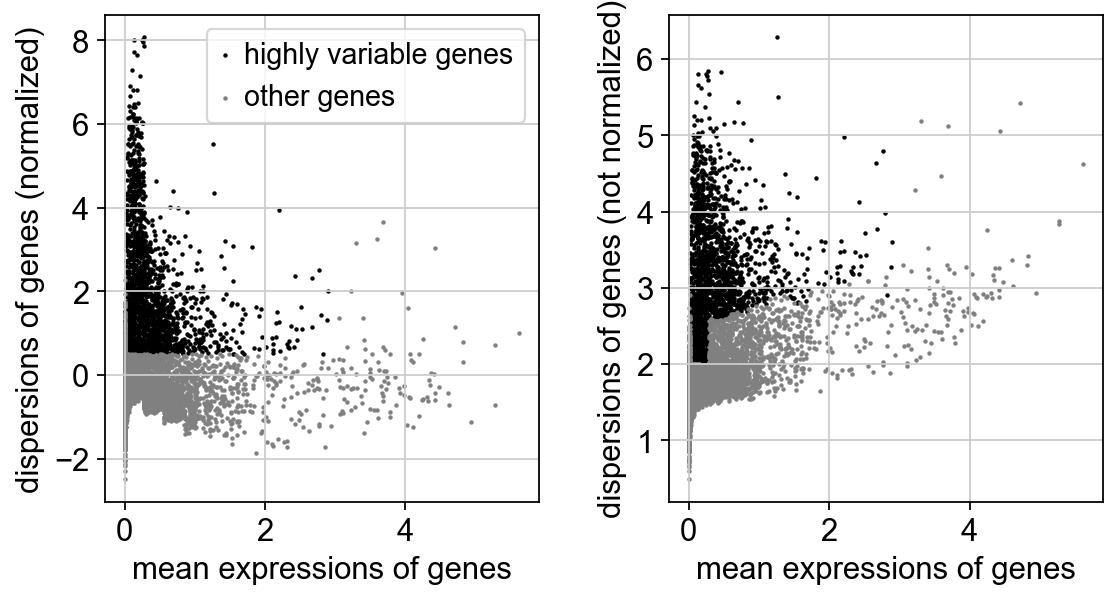

In [16]:
sc.pl.highly_variable_genes(adata)

In [17]:
adata.raw = adata # Store the raw data before changing the dataset

adata = adata[:, adata.var.highly_variable] # Keeping only the most variable genes

sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt']) # Regressing to minimize the impact of these variables

regressing out ['total_counts', 'pct_counts_mt']
    sparse input is densified and may lead to high memory use
    finished (0:00:04)


In [18]:
sc.pp.scale(adata, max_value=10) # Scale data (divide by sd) and clip values exceeding 10 in sd
sc.tl.pca(adata, svd_solver='arpack')

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:00)


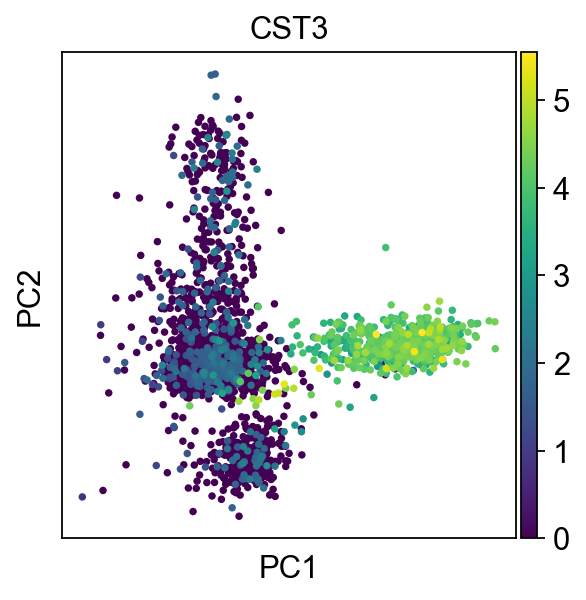

In [19]:
# PCA (reduce dimensions : denoises the data and reveals the main axes of variation)

sc.pl.pca(adata, color='CST3')

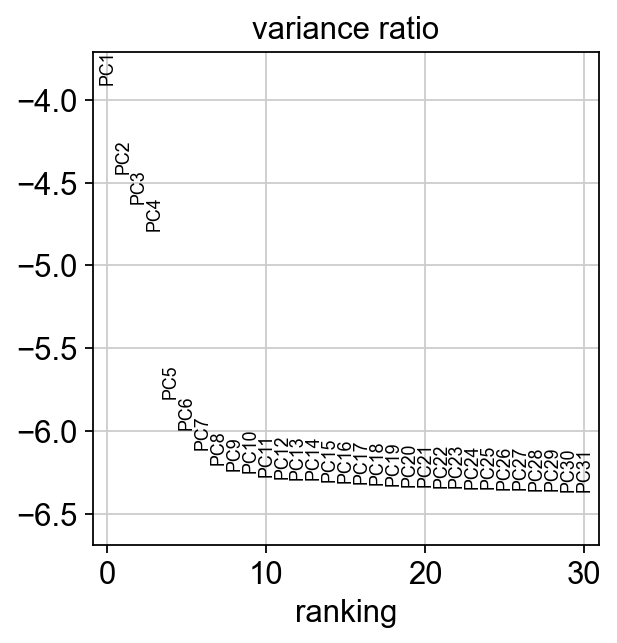

In [20]:
sc.pl.pca_variance_ratio(adata, log=True)

# Neighborhood graph

In [21]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)

computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:01)


running Leiden clustering
    finished: found 8 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)
running PAGA
    finished: added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns) (0:00:00)
--> added 'pos', the PAGA positions (adata.uns['paga'])


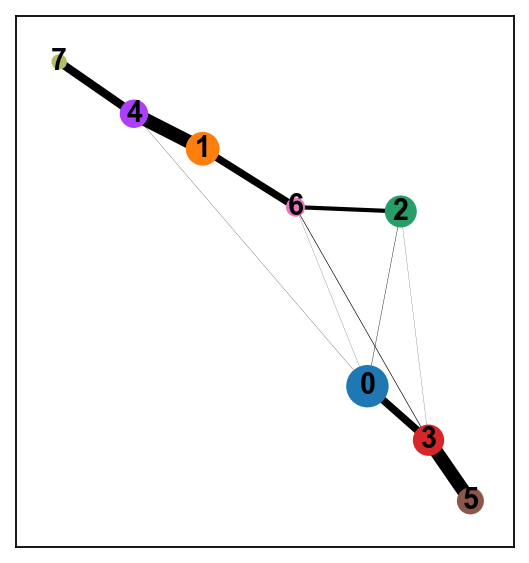

In [35]:
# If we see disconnected clusters and similar connectivity violations
## Run
sc.tl.paga(adata) 
sc.pl.paga(adata)

### Umap
sc.tl.umap(adata, init_pos='paga')


# Else
## Just run 
sc.tl.umap(adata, init_pos='paga')

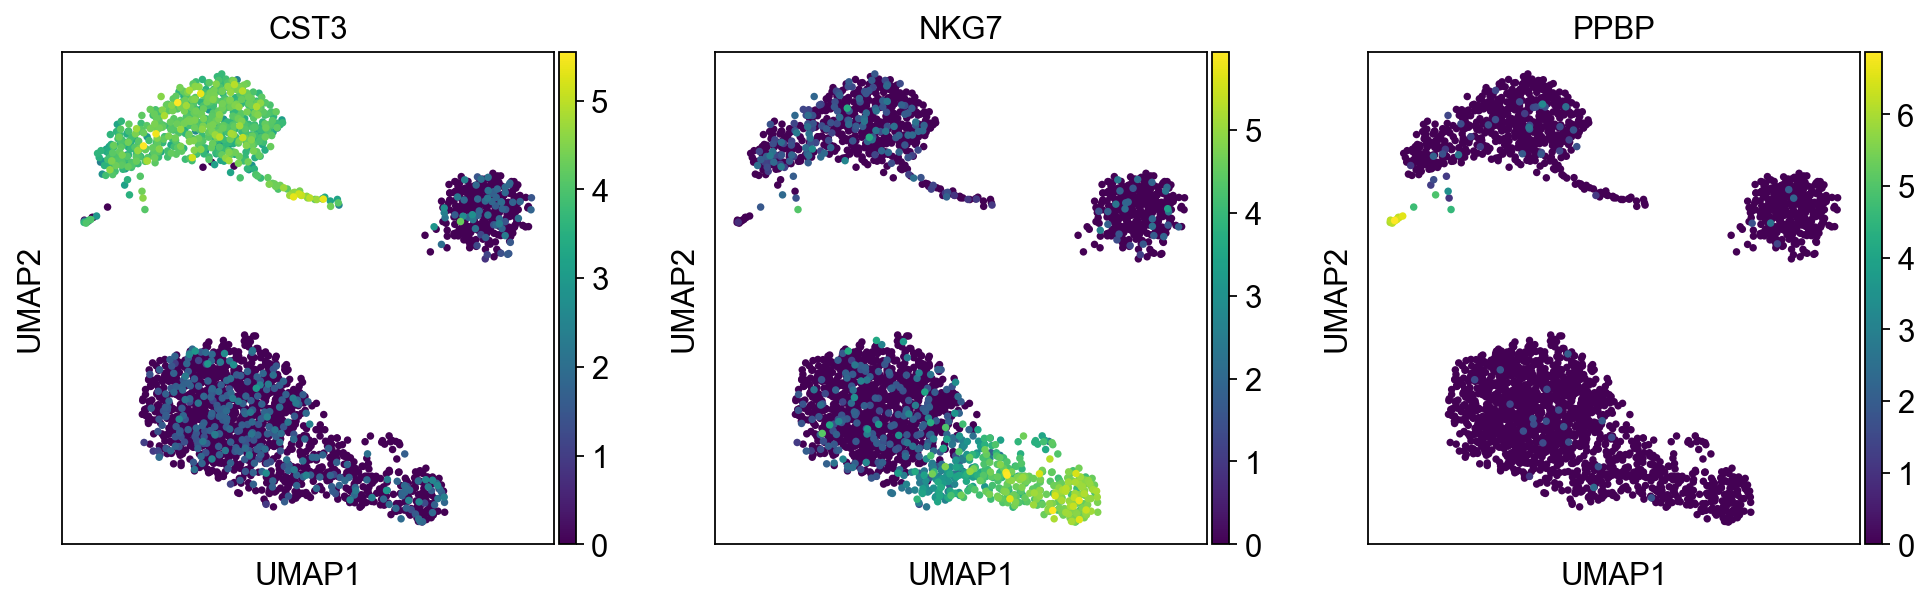

In [38]:
# Umap plot

sc.pl.umap(adata, color=['CST3', 'NKG7', 'PPBP'])

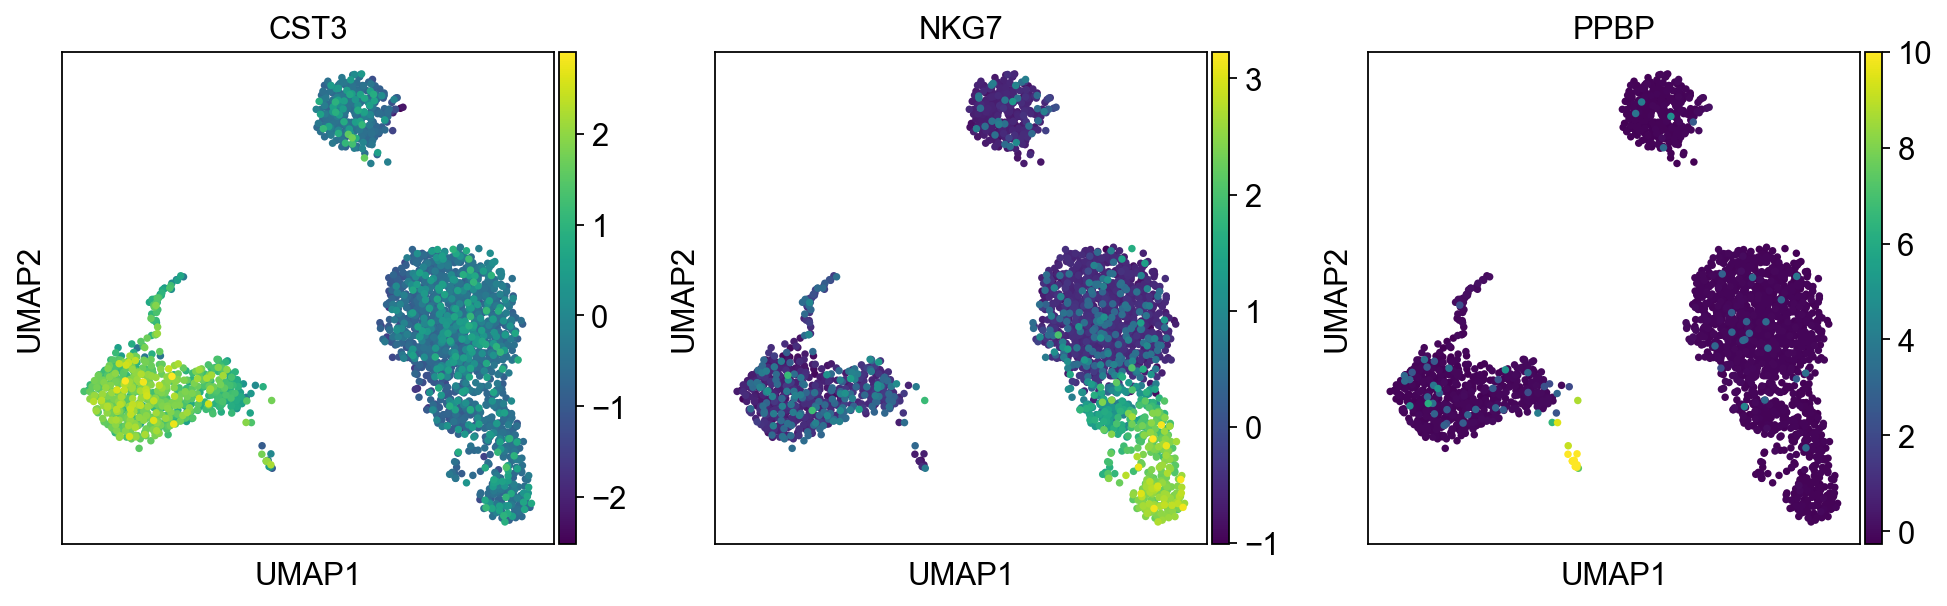

In [40]:
# As we set the .raw attribute of adata, the previous plots showed the “raw” 
#(normalized, logarithmized, but uncorrected) gene expression. 
#You can also plot the scaled and corrected gene expression by explicitly stating that you don’t want to use .raw.


sc.pl.umap(adata, color=['CST3', 'NKG7', 'PPBP'], use_raw=False)


running Leiden clustering
    finished: found 8 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


/Users/mscavino/miniconda3/envs/scanpy/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


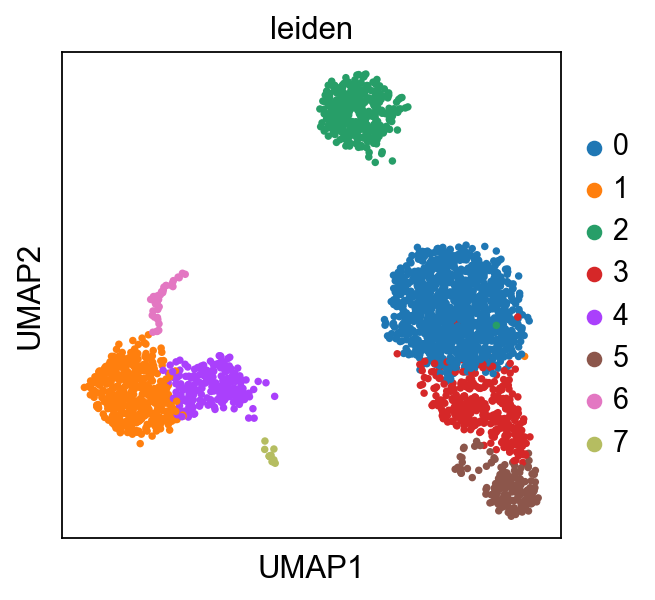

In [41]:
# Clustering the neighborhood graoh


sc.tl.leiden(adata) # Leiden algorithm

sc.pl.umap(adata, color = "leiden") # Color by clusters

In [ ]:
# Save the results

# adata.write(results_file)

# Find marker genes

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


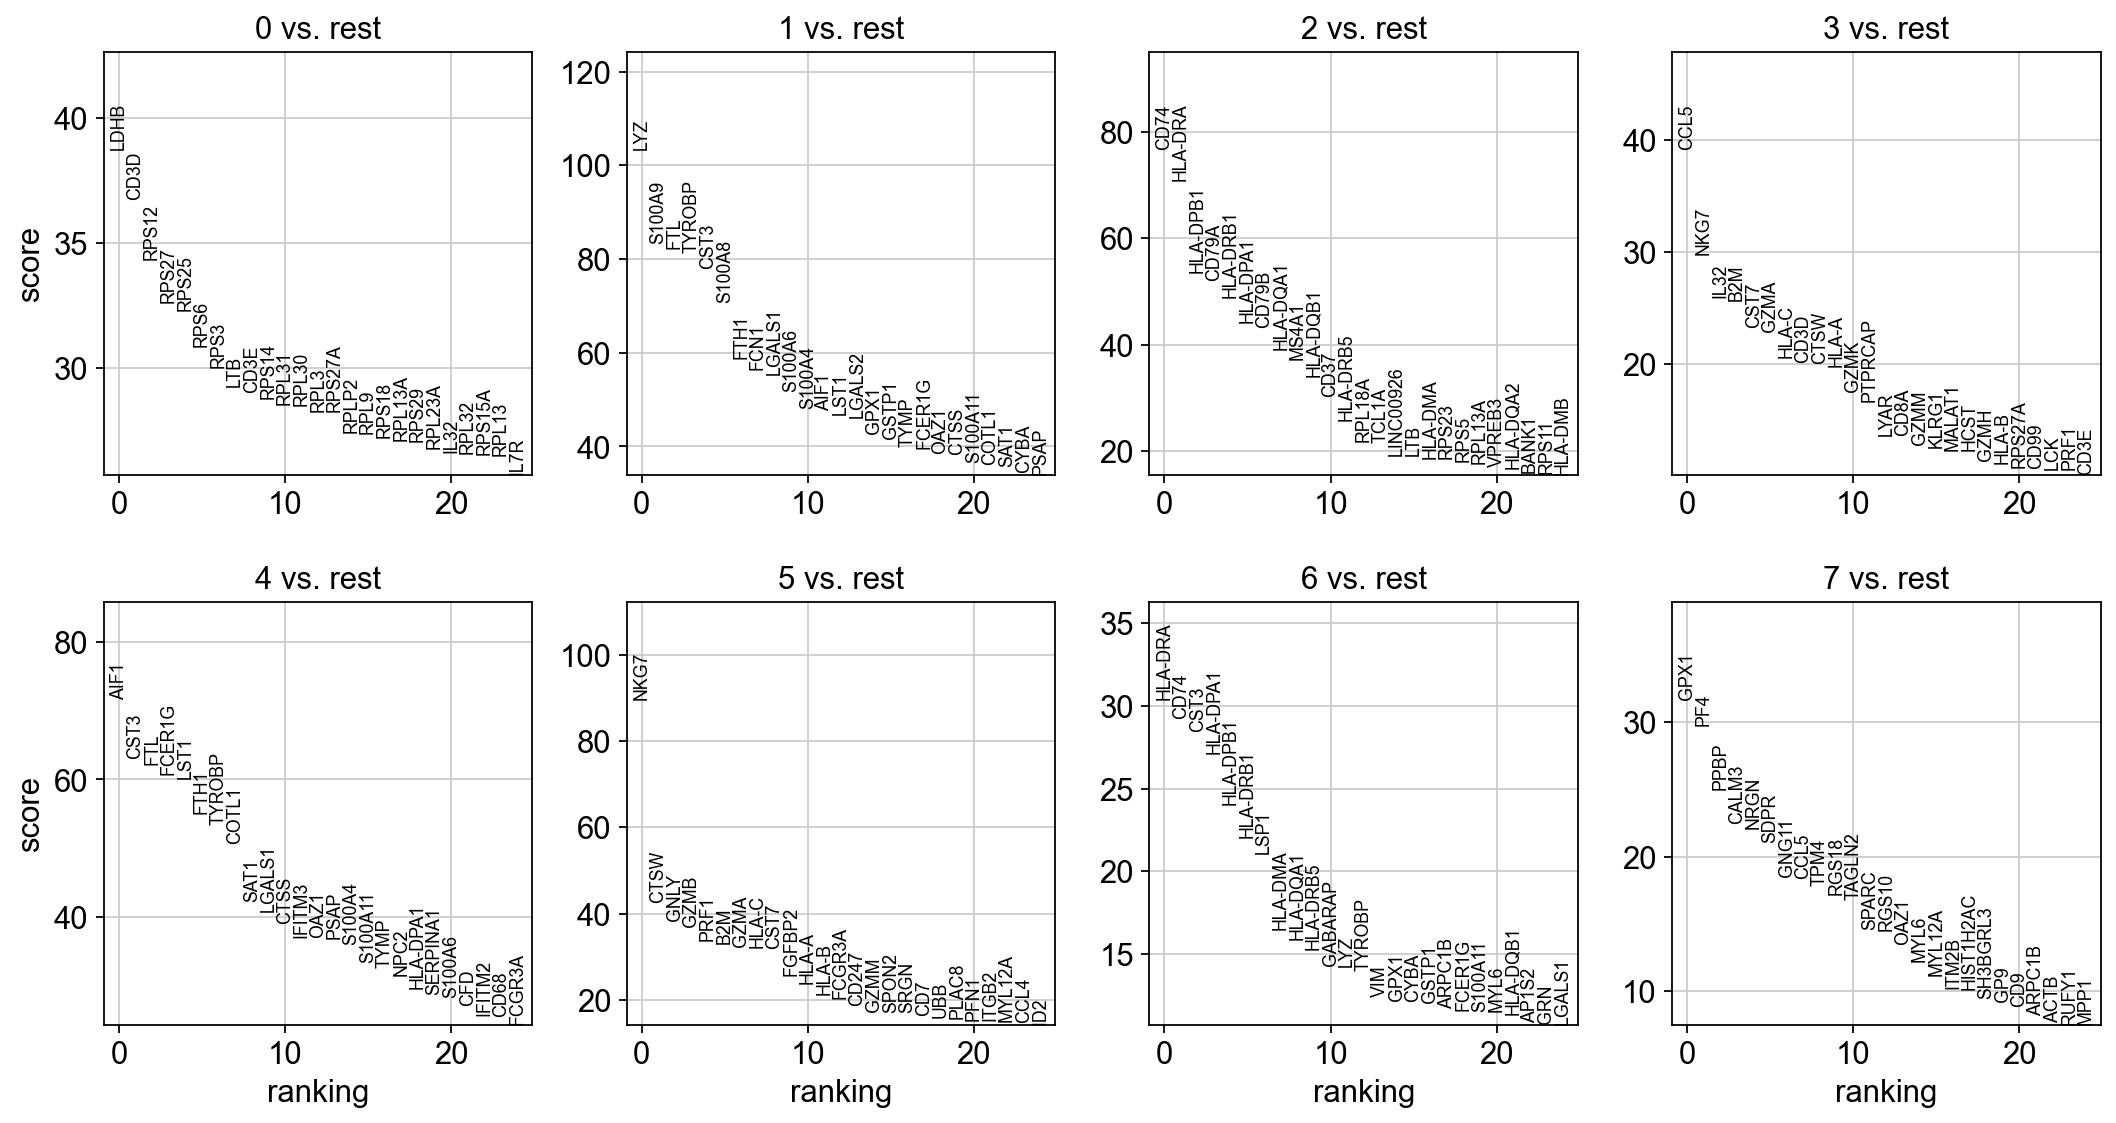

In [45]:
# Find marker genes in each cluster (leiden) of the dataset vs the others using t-test
sc.tl.rank_genes_groups(adata, 'leiden', method='t-test')


# Plot the 25 first genes of each cluster
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False) # Sharey = Share y axis between plots

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:03)


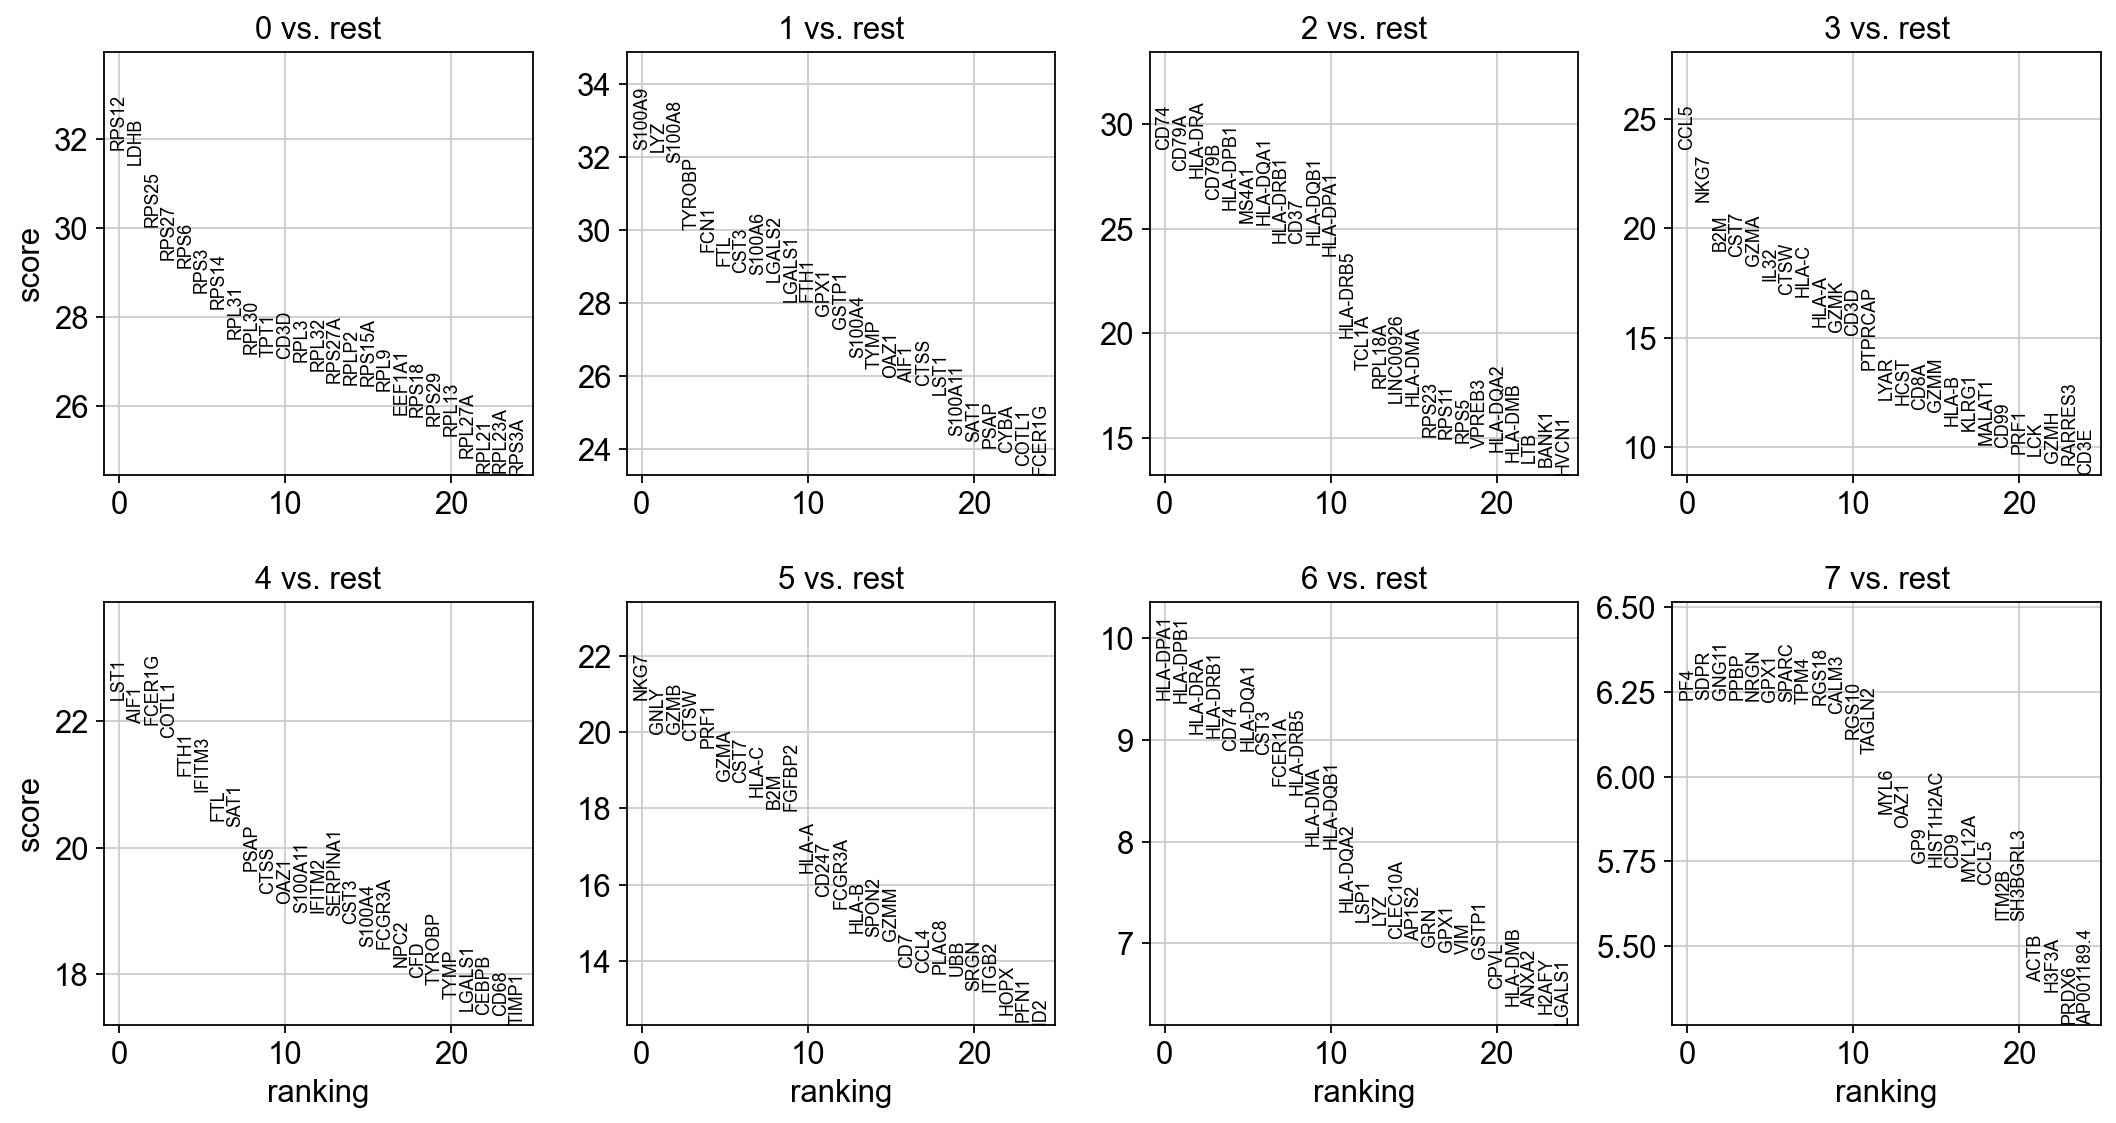

In [67]:
# Same thing but using the wilcoxon method
sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon')

sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
 (0:00:05)


/Users/mscavino/miniconda3/envs/scanpy/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


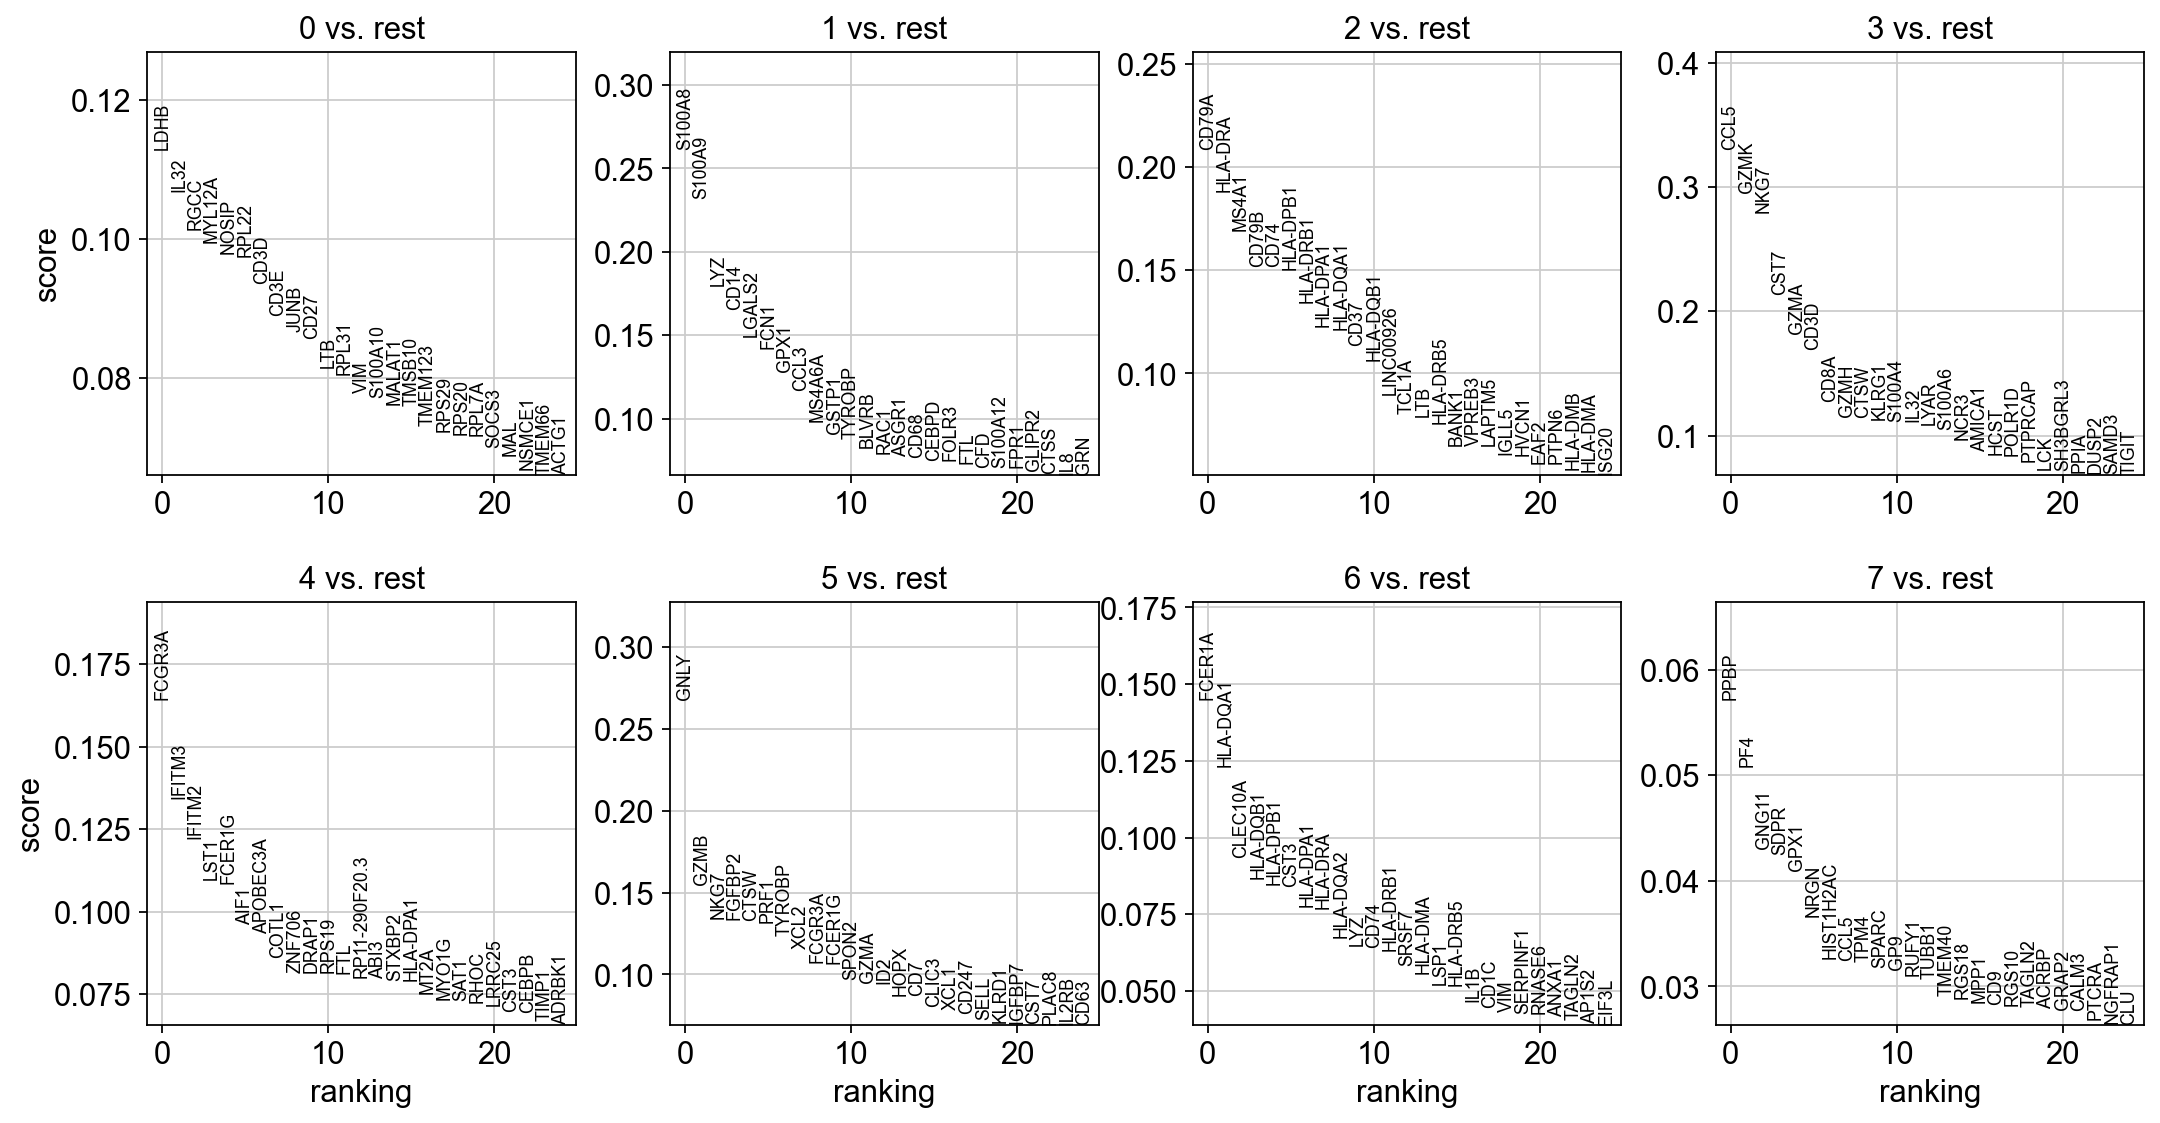

In [47]:
# Same thing with logistic regression (multivariate approach vs univariate for the others)

# sc.tl.rank_genes_groups(adata, 'leiden', method='logreg')
# sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [48]:
marker_genes = ['IL7R', 'CD79A', 'MS4A1', 'CD8A', 'CD8B', 'LYZ', 'CD14',
                'LGALS3', 'S100A8', 'GNLY', 'NKG7', 'KLRB1',
                'FCGR3A', 'MS4A7', 'FCER1A', 'CST3', 'PPBP']

In [49]:
# Command to reload an object saved with adata.write(<path>)

# adata = sc.read(results_file)

In [51]:
# Show the top 5 ranked genes per cluster

pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(5)

,0,1,2,3,4,5,6,7
0,LDHB,S100A8,CD79A,CCL5,FCGR3A,GNLY,FCER1A,PPBP
1,IL32,S100A9,HLA-DRA,GZMK,IFITM3,GZMB,HLA-DQA1,PF4
2,RGCC,LYZ,MS4A1,NKG7,IFITM2,NKG7,CLEC10A,GNG11
3,MYL12A,CD14,CD79B,CST7,LST1,FGFBP2,HLA-DQB1,SDPR
4,NOSIP,LGALS2,CD74,GZMA,FCER1G,CTSW,HLA-DPB1,GPX1


In [64]:
# Dataframe with each marker genes associated to its pval

result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names

pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'pvals']}).head(5)

,0_n,0_p,1_n,1_p,2_n,2_p,3_n,3_p,4_n,4_p,5_n,5_p,6_n,6_p,7_n,7_p
0,RPS12,1.698283e-221,S100A9,1.842655e-227,CD74,3.043536e-182,CCL5,3.352769e-123,LST1,1.421251e-110,NKG7,1.203971e-96,HLA-DPA1,5.422417e-21,PF4,4.722886e-10
1,LDHB,7.449917e-217,LYZ,8.413552e-227,CD79A,6.860832e-170,NKG7,7.222913e-100,AIF1,7.130846e-107,GNLY,1.257170e-88,HLA-DPB1,7.591860e-21,SDPR,4.733899e-10
2,RPS25,3.836151e-198,S100A8,1.257243e-222,HLA-DRA,8.398068e-166,B2M,1.665068e-80,FCER1G,1.045064e-106,GZMB,1.429027e-88,HLA-DRA,1.306768e-19,GNG11,4.733899e-10
3,RPS27,1.199921e-188,TYROBP,6.067012e-198,CD79B,1.171444e-153,CST7,3.474744e-78,COTL1,9.908055e-105,CTSW,4.144726e-87,HLA-DRB1,1.865104e-19,PPBP,4.744938e-10
4,RPS6,3.118787e-186,FCN1,4.894805e-190,HLA-DPB1,6.167786e-148,GZMA,9.060253e-75,FTH1,3.935567e-99,PRF1,1.692100e-85,CD74,5.853161e-19,NRGN,4.800511e-10


ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:02)


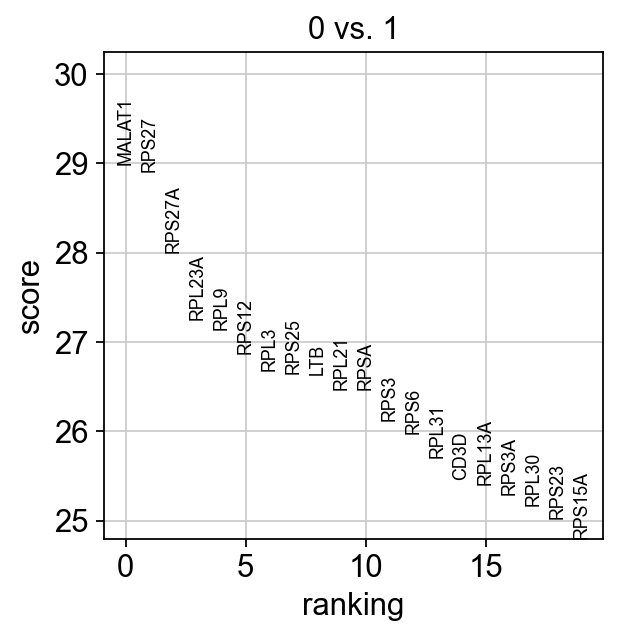

In [65]:
# Compare to a single cluster (compare cluster 0 to cluster 1)

sc.tl.rank_genes_groups(adata, 'leiden', groups=['0'], reference='1', method='wilcoxon')
sc.pl.rank_genes_groups(adata, groups=['0'], n_genes=20)

/Users/mscavino/miniconda3/envs/scanpy/lib/python3.8/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)


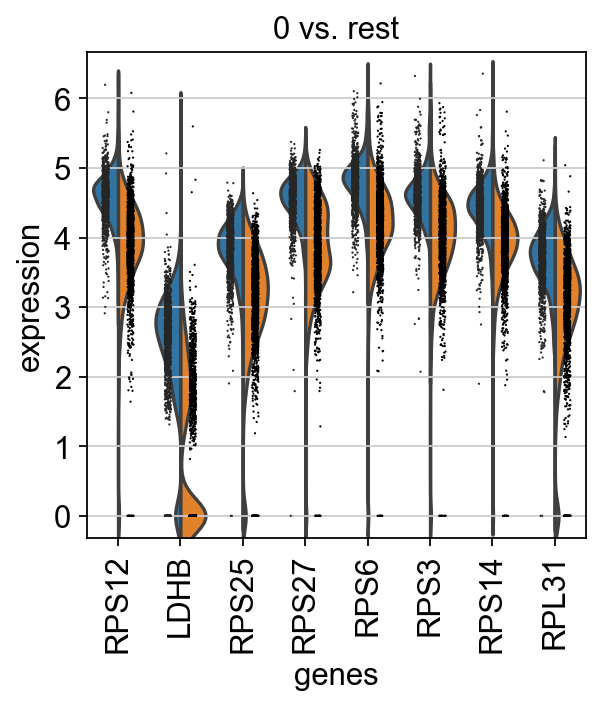

In [70]:
# Visualisation of the gene expression differencies between 2 groups

sc.pl.rank_genes_groups_violin(adata, groups='0', n_genes=8)

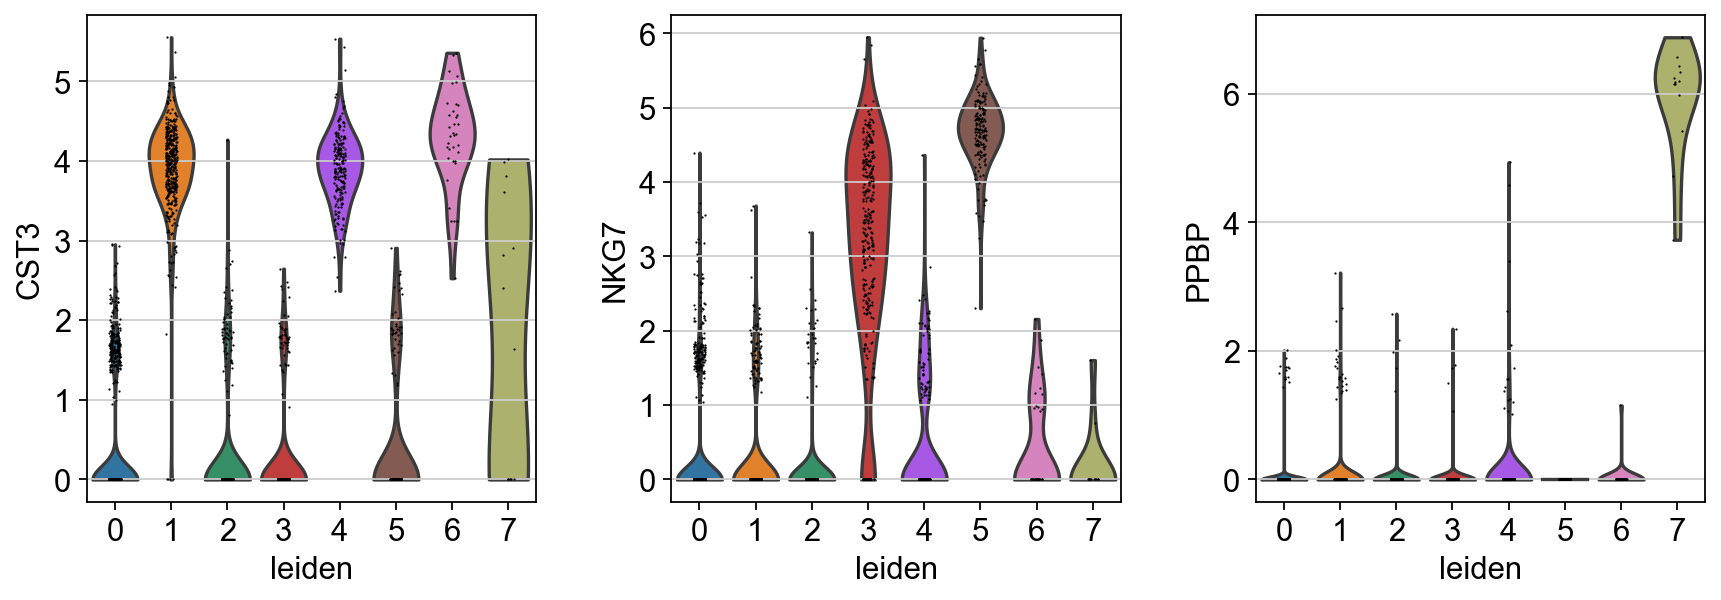

In [71]:
# To compare a certain gene expression among the clusters

sc.pl.violin(adata, ['CST3', 'NKG7', 'PPBP'], groupby='leiden')

/Users/mscavino/miniconda3/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1160: FutureWarning: The `inplace` parameter in pandas.Categorical.rename_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  self.obs[key].cat.rename_categories(categories, inplace=True)
/Users/mscavino/miniconda3/envs/scanpy/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


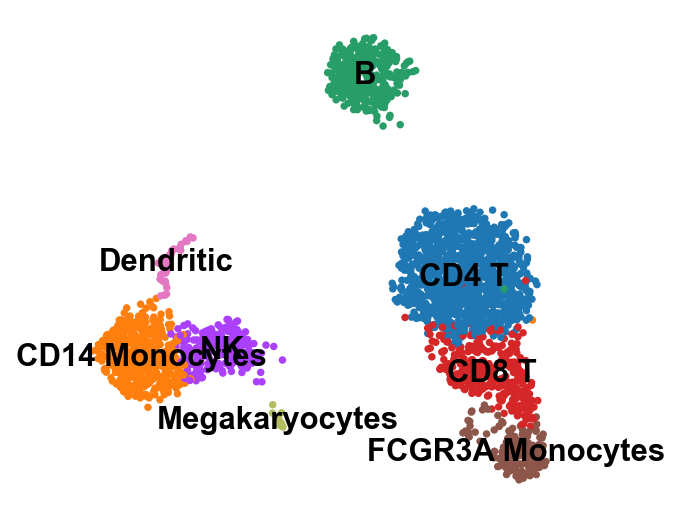

In [73]:
# Mark the cell type

new_cluster_names = [
    'CD4 T', 'CD14 Monocytes',
    'B', 'CD8 T',
    'NK', 'FCGR3A Monocytes',
    'Dendritic', 'Megakaryocytes']
adata.rename_categories('leiden', new_cluster_names)

sc.pl.umap(adata, color='leiden', legend_loc='on data', title='', frameon=False, save='.pdf')

/Users/mscavino/miniconda3/envs/scanpy/lib/python3.8/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


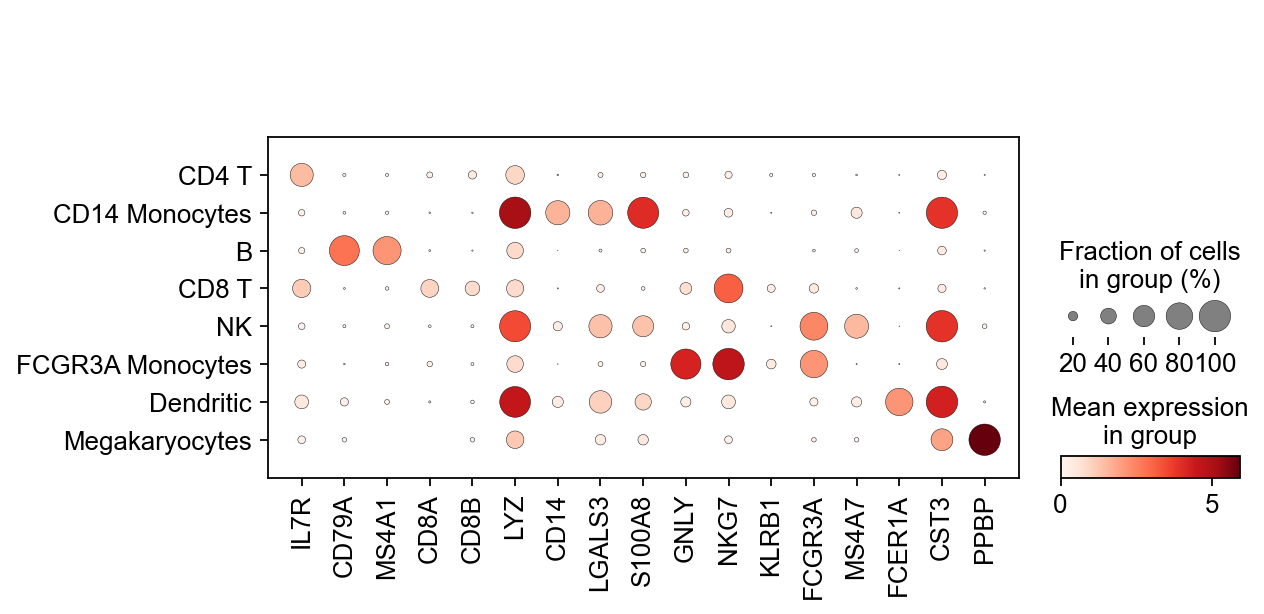

In [76]:
# Dotplot of gene expression

sc.pl.dotplot(adata, marker_genes, groupby='leiden');

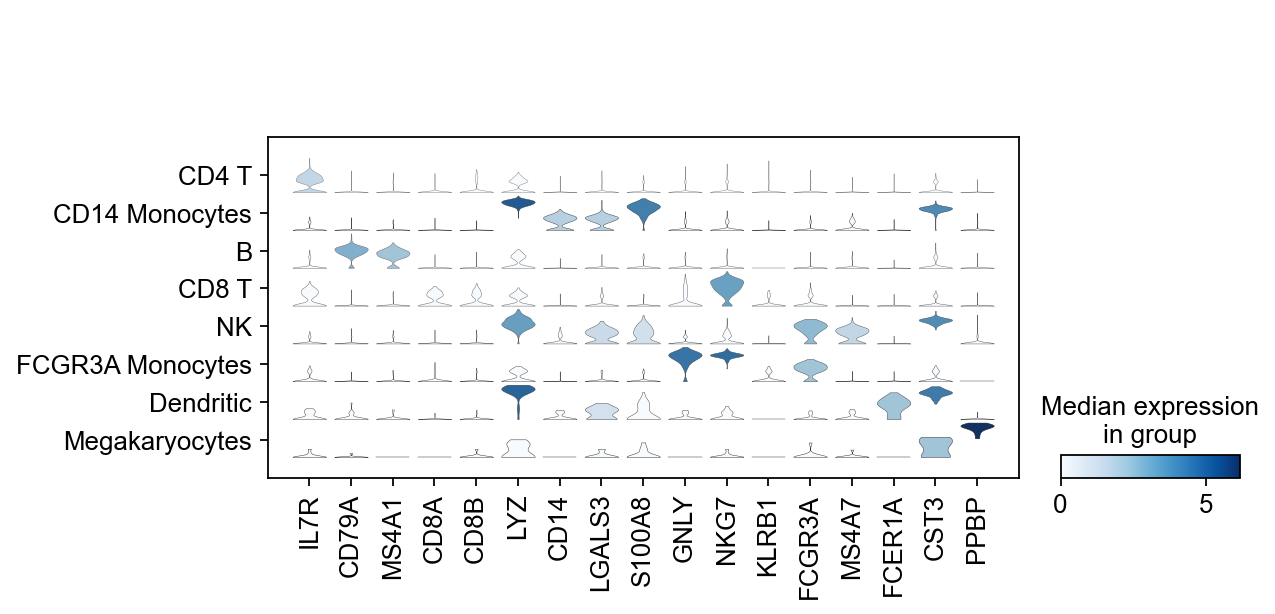

In [78]:
# Same informations as dotplot but with violin plot (less visual)

sc.pl.stacked_violin(adata, marker_genes, groupby='leiden', rotation=90);